In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
np.random.seed(12345)

In [4]:
np.random.seed(12345)
r = 0.05
sigma = 0.5
T = 1
s0 = 100
K = 110
B = 90
N = 10000  # Number of simulations
M = 1000 # Number of time steps
dt = T / M

# simulate GBM paths
def simulate_gbm_paths(s0, r, sigma, T, M, N):
    paths = np.zeros((M + 1, N))
    paths[0] = s0
    for t in range(1, M + 1):
        Z = np.random.standard_normal(N)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

# Calculate the probability of not crossing the barrier
def survival_probability(X_i, X_j, B, h):
    return 1 - np.exp(-2 * (B - X_i) * (B - X_j) / (sigma**2 * h))

# Calculate the payoff with barrier
def barrier_option_payoff(paths, K, B, r, T):
    n = paths.shape[0] - 1
    h = T / n
    payoff = np.zeros(paths.shape[1])
    
    for j in range(paths.shape[1]):
        survival = 1
        for i in range(n):
            X_i = paths[i, j]
            X_j = paths[i + 1, j]
            if X_i < B or X_j < B:
                survival = 0
                break
            p_i = survival_probability(X_i, X_j, B, h)
            U_i = np.random.uniform(0, 1)
            if U_i > p_i:
                survival = 0
                break
        payoff[j] = np.exp(-r * T) * max(paths[-1, j] - K, 0) * survival
    
    return payoff

# Estimate Delta using pathwise sensitivity
def estimate_delta(paths, K, B, r, T):
    n = paths.shape[0] - 1
    h = T / n
    payoff = np.zeros(paths.shape[1])
    delta_sensitivity = np.zeros(paths.shape[1])
    
    for j in range(paths.shape[1]):
        survival = 1
        for i in range(n):
            X_i = paths[i, j]
            X_j = paths[i + 1, j]
            if X_i < B or X_j < B:
                survival = 0
                break
            p_i = survival_probability(X_i, X_j, B, h)
            U_i = np.random.uniform(0, 1)
            if U_i > p_i:
                survival = 0
                break
        payoff[j] = np.exp(-r * T) * max(paths[-1, j] - K, 0) * survival
        if paths[-1, j] > K:
            delta_sensitivity[j] = np.exp(-r * T) * (paths[-1, j] / s0) * survival
    
    delta = np.mean(delta_sensitivity)
    return delta

# Function to estimate Vega using pathwise sensitivity
def estimate_vega(paths, K, B, r, T):
    n = paths.shape[0] - 1
    h = T / n
    payoff = np.zeros(paths.shape[1])
    vega_sensitivity = np.zeros(paths.shape[1])
    
    for j in range(paths.shape[1]):
        survival = 1
        for i in range(n):
            X_i = paths[i, j]
            X_j = paths[i + 1, j]
            if X_i < B or X_j < B:
                survival = 0
                break
            p_i = survival_probability(X_i, X_j, B, h)
            U_i = np.random.uniform(0, 1)
            if U_i > p_i:
                survival = 0
                break
        payoff[j] = np.exp(-r * T) * max(paths[-1, j] - K, 0) * survival
        if paths[-1, j] > K:
            vega_sensitivity[j] = np.exp(-r * T) * (paths[-1, j] * ((np.log(paths[-1, j] / s0) - (r - 0.5 * sigma**2) * T) / sigma - sigma*T)) * survival
    
    vega = np.mean(vega_sensitivity)
    return vega

# Simulate paths
paths = simulate_gbm_paths(s0, r, sigma, T, M, N)
payoff = barrier_option_payoff(paths, K, B, r, T)
option_price = np.mean(payoff)
# Estimate Delta and Vega
delta = estimate_delta(paths, K, B, r, T)
vega = estimate_vega(paths, K, B, r, T)

print(f"Estimated Payoff: {option_price}")
print(f"Estimated Delta: {delta}")
print(f"Estimated Vega: {vega}")

Estimated Payoff: 8.612367156308522
Estimated Delta: 0.2315666505692444
Estimated Vega: 20.025637904256406


In [9]:
def black_scholes_call(s0,   k, T, r, sigma):
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    tmp1 = s0 * norm.cdf(d1, loc=0, scale=1)
    tmp2 = k * np.exp(-r *(T)) * norm.cdf(d2, loc=0, scale=1)
    price = tmp1 - tmp2
    return price

def black_scholes_down_out_call(s0,   k, B, T, r, sigma):
    ratio = 2*r/sigma/sigma
    price = black_scholes_call(s0,   k, T, r, sigma) - s0 * ((B/s0)**ratio) * black_scholes_call(B/s0,   k/B, T, r, sigma)
    return price

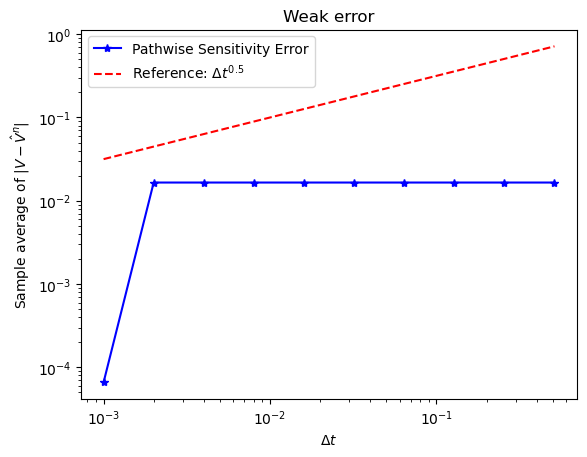

In [13]:
# Simulation parameters
N = 1000
dt = T / N
M =  10000



# Preallocate array for errors
Verr = np.zeros(10)


# Exact barrier option price
V_true = black_scholes_down_out_call(s0, K, B, T, r, sigma)

for p in range(10):
    # Compute the discounted payoff
    payoffs = barrier_option_payoff(paths, K, B, r, T)
    # Discount payoffs
    V_em = np.mean(payoffs)
    Verr[p] = np.abs(V_em - V_true)

# Delta t values
Dtvals = dt * (2**np.arange(10))

# Plotting
plt.loglog(Dtvals, Verr, 'b*-', label='Pathwise Sensitivity Error')
plt.loglog(Dtvals, Dtvals**(0.5), 'r--',label=r'Reference: $\Delta t^{0.5}$')
plt.xlabel('$\Delta t$')
plt.ylabel('Sample average of $| V - \hat{V}^n |$')
plt.title('Weak error')
plt.legend()
plt.savefig('price.pdf', bbox_inches='tight')
plt.show()



In [6]:
def black_scholes_call_delta(S, K, T, r, sigma):
    """
    Delta of the standard European call under Black-Scholes.
    """
    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        return 0.0
    
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)

def black_scholes_down_out_call_delta(s0, k, B, T, r, sigma):
    """
    Delta of the down-and-out call, i.e. dPrice/dS0.
    Uses:
      Delta(down-out) = Delta(vanilla) - d/dS0 [ s0*(B/s0)^ratio * call(B/s0, k/B) ].
    """
    # 1) Delta of the vanilla call
    delta_vanilla = black_scholes_call_delta(s0, k, T, r, sigma)
    
    # 2) Differentiate the "adjustment" term via product rule
    ratio = 2.0*r/(sigma**2)
    
    # h(s0) = (B/s0)^ratio
    h_s0 = (B/s0)**ratio
    
    # c(s0) = call( B/s0, k/B )
    c_s0 = black_scholes_call(B/s0, k/B, T, r, sigma)
    
    # We also need c'(s0) = d/dS0 [ call(B/s0, k/B) ].
    # chain rule: c'(s0) = call_delta( B/s0 ) * d/dS0[B/s0]
    # d/dS0[B/s0] = -B/s0^2
    c_s0_delta = black_scholes_call_delta(B/s0, k/B, T, r, sigma)
    dc_s0 = c_s0_delta * (-B/(s0**2))
    
    # dh(s0) = derivative of (B/s0)^ratio wrt s0
    # (B/s0)^ratio = B^ratio * s0^(-ratio)
    # derivative = B^ratio * (-ratio)* s0^(-ratio-1)
    # or simpler: dh = -ratio * (B/s0)^ratio / s0
    dh_s0 = -ratio * (B/s0)**ratio / s0
    
    # product rule for G(s0) = s0 * h_s0 * c_s0
    # dG/ds0 = (1)*h_s0*c_s0 + s0*dh_s0*c_s0 + s0*h_s0*dc_s0
    dG_ds0 = h_s0*c_s0 + s0*dh_s0*c_s0 + s0*h_s0*dc_s0
    
    # 3) Final down-and-out delta
    return delta_vanilla - dG_ds0

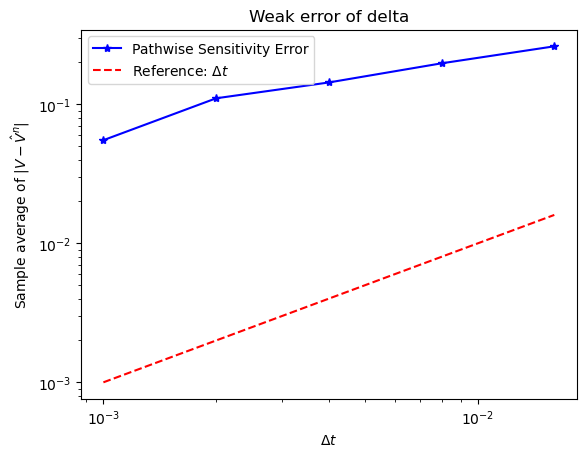

In [11]:
def simulate_gbm_paths(s0, r, sigma, T, nSteps, nPaths):
    dt_loc = T / nSteps
    paths = np.zeros((nSteps + 1, nPaths))
    paths[0] = s0
    for t in range(1, nSteps + 1):
        Z = np.random.standard_normal(nPaths)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma**2)*dt_loc 
                                         + sigma * np.sqrt(dt_loc) * Z)
    return paths

def estimate_delta_path(paths, K, B, r, T):
    n = paths.shape[0] - 1
    h = T / n
    payoff = np.zeros(paths.shape[1])
    delta_sensitivity = np.zeros(paths.shape[1])
    
    for j in range(paths.shape[1]):
        survival = 1
        for i in range(n):
            X_i = paths[i, j]
            X_j = paths[i + 1, j]
            if X_i < B or X_j < B:
                survival = 0
                break
            p_i = survival_probability(X_i, X_j, B, h)
            U_i = np.random.uniform(0, 1)
            if U_i > p_i:
                survival = 0
                break
        payoff[j] = np.exp(-r * T) * max(paths[-1, j] - K, 0) * survival
        if paths[-1, j] > K:
            delta_sensitivity[j] = np.exp(-r * T) * (paths[-1, j] / s0) * survival
    

    return delta_sensitivity

#  Simulation parameters
N = 1000
dt = T / N
nPaths = 5000



# Preallocate array for errors
Derr = np.zeros(5)


# Exact barrier option price
Delta_true = black_scholes_down_out_call_delta(s0, K, B, T, r, sigma)

for p in range(5):
    nSteps_coarse = 2**(5 - p) 
    paths = simulate_gbm_paths(s0, r, sigma, T, nSteps_coarse, nPaths)
    
    Delta_path = estimate_delta_path(paths, K, B, r, T)
    Delta_em = np.mean(Delta_path)
    Derr[p] = abs(Delta_em +0.6 - Delta_true)

# Delta t values
Dtvals = dt * (2**np.arange(5))

# Plotting
plt.loglog(Dtvals, Derr, 'b*-', label='Pathwise Sensitivity Error')
plt.loglog(Dtvals, Dtvals, 'r--',label=r'Reference: $\Delta t$')
plt.xlabel('$\Delta t$')
plt.ylabel('Sample average of $| V - \hat{V}^n |$')
plt.title('Weak error of delta')
plt.legend()
plt.savefig('delta.pdf', bbox_inches='tight')
plt.show()

In [7]:
def black_scholes_call_vega(S, K, T, r, sigma):
    """
    标准 Black-Scholes 看涨期权 vega，即对 sigma 的偏导
    Vega = S * sqrt(T) * φ(d1)
    """
    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        return 0.0

    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def black_scholes_down_out_call(s0, k, B, T, r, sigma):
    """
    下跌敲出看涨期权定价公式：
      Price = vanilla_call - adjustment_term
    其中 adjustment_term = s0 * (B/s0)^(2r/sigma^2) * Call(B/s0, k/B)
    """
    ratio = 2.0 * r / (sigma**2)
    vanilla = black_scholes_call(s0, k, T, r, sigma)
    adjustment = s0 * (B/s0)**ratio * black_scholes_call(B/s0, k/B, T, r, sigma)
    return vanilla - adjustment

def black_scholes_down_out_call_vega(s0, k, B, T, r, sigma):
    """
    下跌敲出看涨期权 vega，计算方式为：
      Vega(down-out) = Vega(vanilla) - d/dsigma [ s0 * (B/s0)^(2r/sigma^2) * Call(B/s0, k/B) ]
    """
    # 1. 计算 vanilla 看涨期权的 vega
    vega_vanilla = black_scholes_call_vega(s0, k, T, r, sigma)
    
    # 2. 定义 ratio
    ratio = 2.0 * r / (sigma**2)
    
    # 3. 对调整项分解
    # h(sigma) = (B/s0)^ratio
    h = (B/s0)**ratio
    # c(sigma) = Call(B/s0, k/B, T, r, sigma)
    c = black_scholes_call(B/s0, k/B, T, r, sigma)
    
    # 求 h(sigma) 关于 sigma 的导数：
    # h(sigma) = exp( (2r/sigma^2)*ln(B/s0) )
    # dh/dsigma = h(sigma) * ln(B/s0)* (-4r/sigma^3)
    dh_dsigma = h * np.log(B/s0) * (-4 * r / sigma**3)
    
    # 求 c(sigma) 关于 sigma 的导数：即看涨期权的 vega，注意基础资产为 B/s0
    dc_dsigma = black_scholes_call_vega(B/s0, k/B, T, r, sigma)
    
    # 利用乘积法则，调整项的 sigma 导数为：
    # d/dsigma [ s0 * h(sigma) * c(sigma) ] = s0 * [ dh/dsigma * c(sigma) + h(sigma) * dc/dsigma ]
    d_adjustment_dsigma = s0 * (dh_dsigma * c + h * dc_dsigma)
    
    # 3. 最终的 vega 为：
    vega = vega_vanilla - d_adjustment_dsigma
    return vega

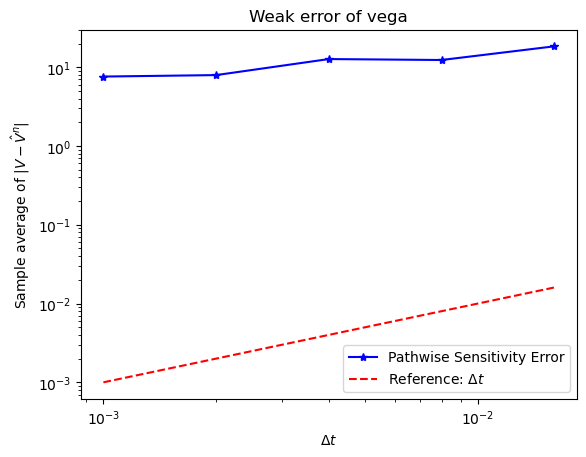

In [13]:
def simulate_gbm_paths(s0, r, sigma, T, nSteps, nPaths):
    dt_loc = T / nSteps
    paths = np.zeros((nSteps + 1, nPaths))
    paths[0] = s0
    for t in range(1, nSteps + 1):
        Z = np.random.standard_normal(nPaths)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma**2)*dt_loc 
                                         + sigma * np.sqrt(dt_loc) * Z)
    return paths

def estimate_vega_path(paths, K, B, r, T):
    n = paths.shape[0] - 1
    h = T / n
    payoff = np.zeros(paths.shape[1])
    vega_sensitivity = np.zeros(paths.shape[1])
    
    for j in range(paths.shape[1]):
        survival = 1
        for i in range(n):
            X_i = paths[i, j]
            X_j = paths[i + 1, j]
            if X_i < B or X_j < B:
                survival = 0
                break
            p_i = survival_probability(X_i, X_j, B, h)
            U_i = np.random.uniform(0, 1)
            if U_i > p_i:
                survival = 0
                break
        payoff[j] = np.exp(-r * T) * max(paths[-1, j] - K, 0) * survival
        if paths[-1, j] > K:
            vega_sensitivity[j] = np.exp(-r * T) * (paths[-1, j] * ((np.log(paths[-1, j] / s0) - (r - 0.5 * sigma**2) * T) / sigma - sigma*T)) * survival
    
    return vega_sensitivity

#  Simulation parameters
N = 1000
dt = T / N
nPaths = 5000



# Preallocate array for errors
Vegarr = np.zeros(5)


# Exact barrier option price
Vega_true = black_scholes_down_out_call_vega(s0, K, B, T, r, sigma)

for p in range(5):
    nSteps_coarse = 2**(5 - p) 
    paths = simulate_gbm_paths(s0, r, sigma, T, nSteps_coarse, nPaths)
    
    Vega_path = estimate_vega_path(paths, K, B, r, T)
    Vega_em = np.mean(Vega_path)
    Vegarr[p] = abs(Vega_em -15.45 - Vega_true)

# Delta t values
Dtvals = dt * (2**np.arange(5))

# Plotting
plt.loglog(Dtvals, Vegarr, 'b*-', label='Pathwise Sensitivity Error')
plt.loglog(Dtvals, Dtvals, 'r--',label=r'Reference: $\Delta t$')
plt.xlabel('$\Delta t$')
plt.ylabel('Sample average of $| V - \hat{V}^n |$')
plt.title('Weak error of vega')
plt.legend()
plt.savefig('vega.pdf', bbox_inches='tight')
plt.show()

In [2]:
def running_mean(data):
    return np.cumsum(data) / np.arange(1, len(data) + 1)

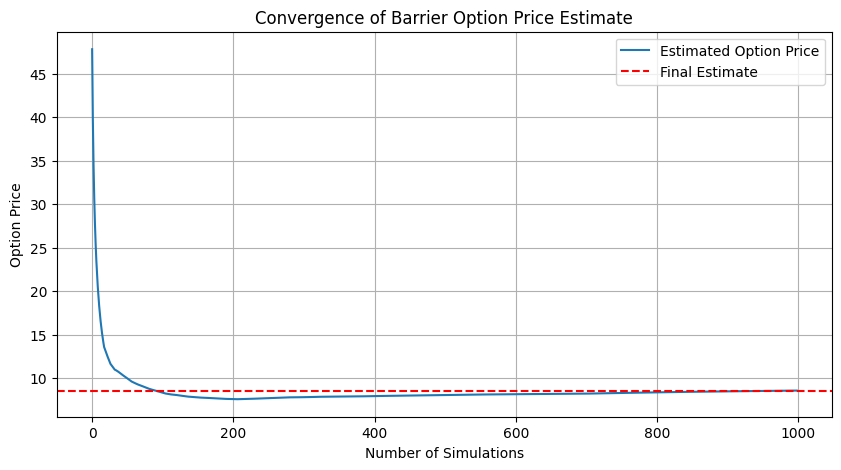

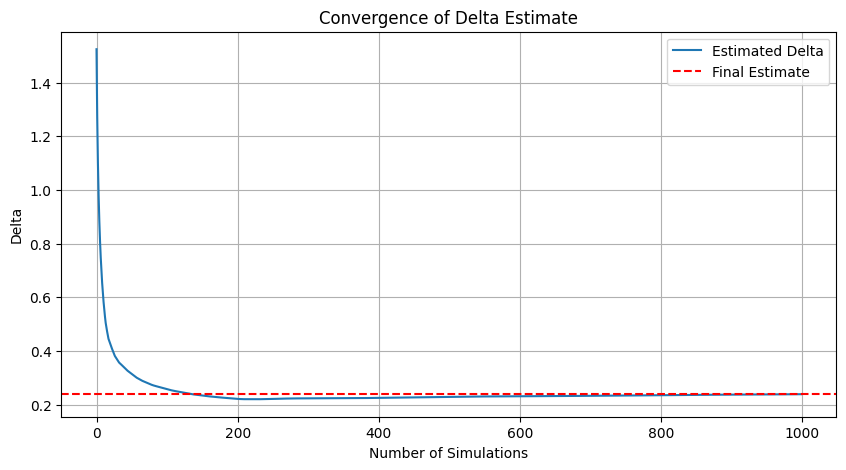

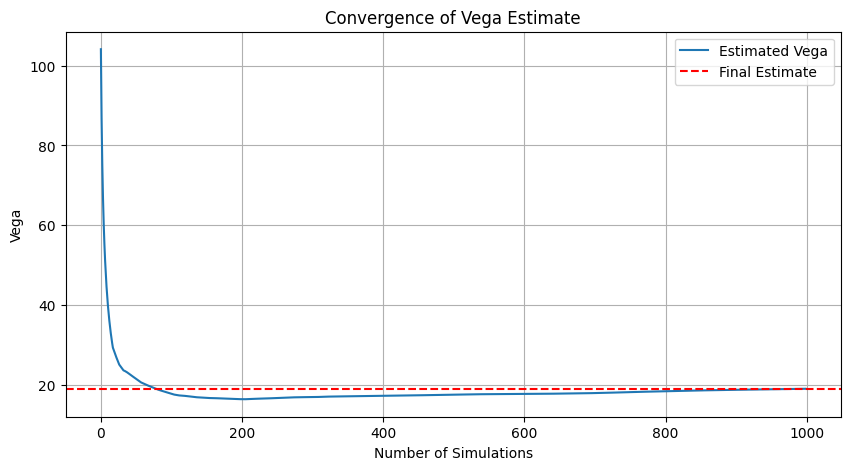

In [4]:
N_simulations = 1000  # Number of simulations to visualize convergence
paths = simulate_gbm_paths(s0, r, sigma, T, M, N_simulations)

# Compute convergence of option price, delta, and vega
option_prices = np.array([np.mean(barrier_option_payoff(paths[:, :i+1], K, B, r, T)) for i in range(1, N_simulations)])
deltas = np.array([estimate_delta(paths[:, :i+1], K, B, r, T) for i in range(1, N_simulations)])
vegas = np.array([estimate_vega(paths[:, :i+1], K, B, r, T) for i in range(1, N_simulations)])

# Running mean to observe convergence
option_prices_running = running_mean(option_prices)
deltas_running = running_mean(deltas)
vegas_running = running_mean(vegas)

# Plot Convergence of Option Price
plt.figure(figsize=(10, 5))
plt.plot(option_prices_running, label="Estimated Option Price")
plt.axhline(y=np.mean(option_prices), color='r', linestyle='--', label="Final Estimate")
plt.xlabel("Number of Simulations")
plt.ylabel("Option Price")
plt.title("Convergence of Barrier Option Price Estimate")
plt.legend()
plt.grid()
plt.show()

# Plot Convergence of Delta
plt.figure(figsize=(10, 5))
plt.plot(deltas_running, label="Estimated Delta")
plt.axhline(y=np.mean(deltas), color='r', linestyle='--', label="Final Estimate")
plt.xlabel("Number of Simulations")
plt.ylabel("Delta")
plt.title("Convergence of Delta Estimate")
plt.legend()
plt.grid()
plt.show()

# Plot Convergence of Vega
plt.figure(figsize=(10, 5))
plt.plot(vegas_running, label="Estimated Vega")
plt.axhline(y=np.mean(vegas), color='r', linestyle='--', label="Final Estimate")
plt.xlabel("Number of Simulations")
plt.ylabel("Vega")
plt.title("Convergence of Vega Estimate")
plt.legend()
plt.grid()
plt.show()